#### IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback

#### DATA PREPARATION

In [2]:
# function provided by the dataset owner for unpickling the data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# loading training dataset
data = np.concatenate((np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_1')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_2')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_3')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_4')[b'data'], dtype='int16'),
                       np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_5')[b'data'], dtype='int16')))
# loading labels for the training data
labels = np.concatenate((np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_1')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_2')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_3')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_4')[b'labels'], dtype='int8'),
                         np.array(unpickle('D:/CIFAR_10_stuff/data/data_batch_5')[b'labels'], dtype='int8')))

In [4]:
data = data.reshape((50000, 1024, 3), order='F').reshape((50000, 32, 32, 3))  # data reshaping into 32x32x3

In [5]:
# defining a augmentation function for training data
train_augmentation = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.15,
                                        height_shift_range=0.15, shear_range=0.15, zoom_range=0.15, horizontal_flip=True)

In [6]:
# creating a training data generator
train_gen = train_augmentation.flow(x=data, y=labels)

In [7]:
# loading validation and testing dataset
test_val_data = np.array(unpickle('D:/CIFAR_10_stuff/data/test_batch')[b'data'], dtype='int16')
test_val_labels = np.array(unpickle('D:/CIFAR_10_stuff/data/test_batch')[b'labels'], dtype='int8')

In [8]:
# splitting to get separated validation and testing datasets
X_val, X_test, y_val, y_test = train_test_split(test_val_data, test_val_labels, test_size=0.5,
                                                stratify=test_val_labels, random_state=42)

In [9]:
X_val = X_val.reshape((5000, 1024, 3), order='F').reshape((5000, 32, 32, 3))  # data reshaping into 32x32x3
X_test = X_test.reshape((5000, 1024, 3), order='F').reshape((5000, 32, 32, 3))  # data reshaping into 32x32x3

In [10]:
# defining a augmentation function for validation and testing data
test_augmentation = ImageDataGenerator(rescale=1./255)

In [11]:
# storing validation and testing datasets as Numpy Array Iterators
val_gen = test_augmentation.flow(x=X_val, y=y_val)
test_gen = test_augmentation.flow(x=X_test, y=y_test)

#### DEFINING STOPPING CALLBACK

In [12]:
class myCallback(Callback):
    # defining callback for accuracy check on epoch end
    def on_epoch_end(self, epoch, logs={}):
        if logs['val_accuracy'] >= 0.95:  # checking if set accuracy has been achieved
            print("\n\n95% Validation Accuracy achieved. Stopping Training!\n")
            self.model.stop_training = True  # stopping the training process

#### CREATING A SPARSE LAYER

In [13]:
class Sparse(tf.keras.layers.Layer):
    
    def __init__(self, units, sparse_indices, activation=None, **kwargs):
        super(Sparse, self).__init__(**kwargs)
        self.units = units
        self.sparse_indices = sparse_indices
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.sparse_w = self.add_weight(
            shape = (len(self.sparse_indices),),
            initializer = "glorot_uniform",
            trainable = True,
            name = "sparse_weights"
        )
        self.b = self.add_weight(
            shape = (self.units,),
            initializer = "zeros",
            trainable = True,
            name = "biases"
        )

    def call(self, inputs):
        output = tf.sparse.sparse_dense_matmul(
            inputs,
            tf.SparseTensor(self.sparse_indices, self.sparse_w, (tf.shape(inputs)[-1], self.units))
        ) + self.b
        
        if self.activation is not None:
            output = self.activation(output)
        
        return output

#### CREATING A CUSTOM INDICES INITIALIZER

In [14]:
def indices(before=None, after=None, lamda=None):
    
    size = int(lamda * (before + after))
    pairs = set()
    
    while len(pairs) < size:
        a = np.random.randint(0, before)
        b = np.random.randint(0, after)
        pairs.add((a, b))

    tensor_pairs = tf.convert_to_tensor(list(pairs), dtype=tf.int64)
    return tensor_pairs

#### CREATING A CONVOLUTIONAL NEURAL NETWORK

In [52]:
def myCNN(image_shape=(32,32,3), model_style=None):
    ''' Define a tf.keras.Model for image classification into 10 categories
    Arguments:
        image_shape -- Image dimensions
        model_style -- style of model to implement: 'dense' or 'sparse'
    Returns:
        tf.keras.Model
    '''
    inputs = Input(shape=image_shape, name='input_layer')

    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = BatchNormalization(name='block1_batchnorm')(x)
    x = MaxPooling2D((2, 2), name='block1_maxpool')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = Dropout(0.5, name='block2_dropout')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = BatchNormalization(name='block2_batchnorm')(x)
    x = MaxPooling2D((2, 2), name='block2_maxpool')(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = Dropout(0.5, name='block3_dropout')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = BatchNormalization(name='block3_batchnorm')(x)
    x = MaxPooling2D((2, 2), name='block3_maxpool')(x)

    flats = Flatten(name='flattening_layer')(x)
    if model_style == 'dense':
        x = Dense(2048, activation='relu', name='dense_01')(flats)
        x = Dropout(0.5, name='dropout_01')(x)
        x = Dense(512, activation='relu', name='dense_02')(x)
        x = Dropout(0.4, name='dropout_02')(x)
        x = Dense(128, activation='relu', name='dense_03')(x)
        x = Dropout(0.3, name='dropout_03')(x)        
        x = Dense(32, activation='relu', name='dense_04')(x)
    else:
        x = Sparse(2048, sparse_indices=indices(flats.shape[-1], 2048, 20), activation='relu', name='sparse_01')(flats)
        x = Dropout(0.5, name='dropout_01')(x)
        x = Sparse(512, sparse_indices=indices(2048, 512, 20), activation='relu', name='sparse_02')(x)
        x = Dropout(0.4, name='dropout_02')(x)
        x = Sparse(128, sparse_indices=indices(512, 128, 20), activation='relu', name='sparse_03')(x)
        x = Dropout(0.3, name='dropout_03')(x)
        x = Sparse(32, sparse_indices=indices(128, 32, 20), activation='relu', name='sparse_04')(x)
    
    outputs = Dense(10, activation='softmax', name='predictions')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

#### DENSE MODEL

In [53]:
model_dense = myCNN(model_style='dense')

model_dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

model_dense.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 32)        896       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 32)        9248      
                                                                 
 block1_batchnorm (BatchNorm  (None, 32, 32, 32)       128       
 alization)                                                      
                                                                 
 block1_maxpool (MaxPooling2  (None, 16, 16, 32)       0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       3699

In [54]:
history_dense = model_dense.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[myCallback()])

Epoch 1/100
1563/1563 [==============================] - 667s 426ms/step - loss: 2.1978 - accuracy: 0.1908 - val_loss: 2.5871 - val_accuracy: 0.1698
Epoch 2/100
1563/1563 [==============================] - 674s 431ms/step - loss: 1.8819 - accuracy: 0.2839 - val_loss: 1.7470 - val_accuracy: 0.3270
Epoch 3/100
1563/1563 [==============================] - 678s 434ms/step - loss: 1.7435 - accuracy: 0.3470 - val_loss: 2.2407 - val_accuracy: 0.2944
Epoch 4/100
1563/1563 [==============================] - 671s 429ms/step - loss: 1.6157 - accuracy: 0.4046 - val_loss: 2.7774 - val_accuracy: 0.2608
Epoch 5/100
1563/1563 [==============================] - 670s 429ms/step - loss: 1.4909 - accuracy: 0.4569 - val_loss: 1.9596 - val_accuracy: 0.3896
Epoch 6/100
1563/1563 [==============================] - 670s 429ms/step - loss: 1.3883 - accuracy: 0.5060 - val_loss: 2.0677 - val_accuracy: 0.3774
Epoch 7/100
1563/1563 [==============================] - 666s 426ms/step - loss: 1.2909 - accuracy: 0.5439

In [55]:
predict_dense = model_dense.evaluate(test_gen)
print("Test Loss:", predict_dense[0])
print("Test Accuracy:", predict_dense[1])

157/157 [==============================] - 20s 121ms/step - loss: 0.3541 - accuracy: 0.8858
Test Loss: 0.3540860712528229
Test Accuracy: 0.8858000040054321


In [56]:
# extracting metrics from training history
training_accuracy_dense = history_dense.history['accuracy']
validation_accuracy_dense = history_dense.history['val_accuracy']
training_loss_dense = history_dense.history['loss']
validation_loss_dense = history_dense.history['val_loss']

#### SPARSE MODEL

In [57]:
model_sparse = myCNN(model_style='sparse')

model_sparse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

model_sparse.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 32)        896       
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 32)        9248      
                                                                 
 block1_batchnorm (BatchNorm  (None, 32, 32, 32)       128       
 alization)                                                      
                                                                 
 block1_maxpool (MaxPooling2  (None, 16, 16, 32)       0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       369

In [58]:
history_sparse = model_sparse.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[myCallback()])

Epoch 1/100
1563/1563 [==============================] - 643s 407ms/step - loss: 1.6824 - accuracy: 0.3775 - val_loss: 1.8792 - val_accuracy: 0.3742
Epoch 2/100
1563/1563 [==============================] - 670s 429ms/step - loss: 1.3688 - accuracy: 0.5074 - val_loss: 1.3689 - val_accuracy: 0.5270
Epoch 3/100
1563/1563 [==============================] - 665s 425ms/step - loss: 1.2188 - accuracy: 0.5664 - val_loss: 1.2892 - val_accuracy: 0.5596
Epoch 4/100
1563/1563 [==============================] - 652s 417ms/step - loss: 1.1300 - accuracy: 0.6001 - val_loss: 1.0779 - val_accuracy: 0.6166
Epoch 5/100
1563/1563 [==============================] - 704s 450ms/step - loss: 1.0609 - accuracy: 0.6266 - val_loss: 1.1208 - val_accuracy: 0.6114
Epoch 6/100
1563/1563 [==============================] - 645s 413ms/step - loss: 1.0010 - accuracy: 0.6454 - val_loss: 0.9758 - val_accuracy: 0.6612
Epoch 7/100
1563/1563 [==============================] - 690s 441ms/step - loss: 0.9599 - accuracy: 0.6649

In [59]:
predict_sparse = model_sparse.evaluate(test_gen)
print("Test Loss:", predict_sparse[0])
print("Test Accuracy:", predict_sparse[1])

157/157 [==============================] - 20s 127ms/step - loss: 0.4677 - accuracy: 0.8456
Test Loss: 0.46773475408554077
Test Accuracy: 0.8456000089645386


In [60]:
# extracting metrics from training history
training_accuracy_sparse = history_sparse.history['accuracy']
validation_accuracy_sparse = history_sparse.history['val_accuracy']
training_loss_sparse = history_sparse.history['loss']
validation_loss_sparse = history_sparse.history['val_loss']

#### MODELS ACCURACY & LOSS PLOTS

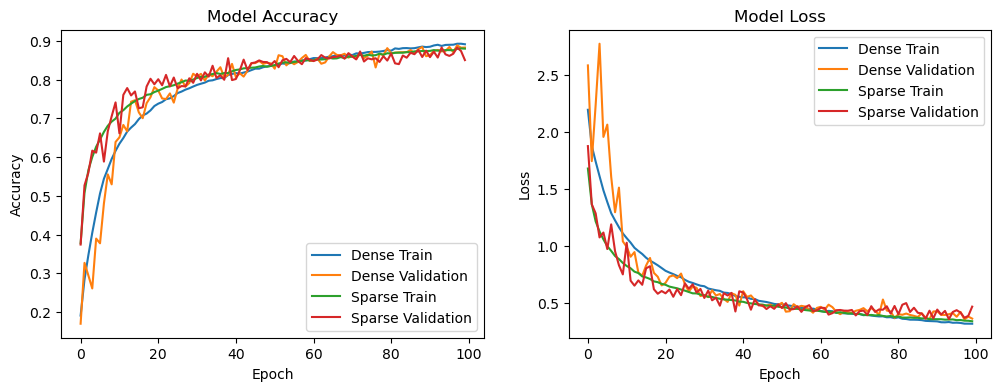

In [67]:
import matplotlib.pyplot as plt

# plotting the metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy_dense)
plt.plot(validation_accuracy_dense)
plt.plot(training_accuracy_sparse)
plt.plot(validation_accuracy_sparse)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'Sparse Train', 'Sparse Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(training_loss_dense)
plt.plot(validation_loss_dense)
plt.plot(training_loss_sparse)
plt.plot(validation_loss_sparse)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Validation', 'Sparse Train', 'Sparse Validation'], loc='upper right')

plt.show()